In [11]:
from torch import nn
import einops
from tqdm.notebook import tqdm

In [12]:
# Define models
class Model(nn.Module):
    def __init__(self, n_features, hidden_dim, n_models, linear=True):
        super().__init__()
        self.w = nn.Parameter(torch.empty((n_models, hidden_dim, n_features)))
        nn.init.kaiming_normal_(self.w) if not linear else nn.init.xavier_normal_(self.w)
        self.b = nn.Parameter(torch.zeros(n_models, n_features))
        self.activ = nn.ReLU() if not linear else nn.Identity()
        
    def forward(self, x):
        h = einops.einsum(self.w, x, "n_models hidden_dim n_features, batch n_models n_features -> batch n_models hidden_dim")
        out = self.activ(einops.einsum(self.w, h, "n_models hidden_dim n_features, batch n_models hidden_dim -> batch n_models n_features")  + self.b)
        return out

In [13]:
import numpy as np
import torch

def generate_synthetic_data(batch_size, n_models, n_features, sparsity):
    data = np.random.rand(batch_size, n_models, n_features)
    sparsity = sparsity.reshape(1, n_models, 1)
    mask = (np.random.rand(batch_size, n_models, n_features) >= sparsity).astype(float)
    data *= mask
    return torch.tensor(data, dtype=torch.float32)

In [22]:
n_features = 80
hidden_dim = 20
n_models = 7
sparsity = [0.0, 0.7, 0.9, 0.97, 0.99, 0.997, 0.999]
importance = torch.tensor([0.9**i for i in range(n_features)])

In [15]:
linear_model = Model(n_features, hidden_dim, 1, linear=True)
nonlinear_model = Model(n_features, hidden_dim, n_models, linear=False)

In [16]:
# Training parameters
learning_rate = 1e-3
batch_size = 1024
steps = 10_000

def train_model(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    pbar = tqdm(range(steps), position=0, leave=True)
    for _ in pbar:
        batch = generate_synthetic_data(batch_size, n_models, n_features, sparsity)
        optimizer.zero_grad()
        output = model(batch) 
        error = importance * (batch.abs() - output) ** 2
        loss = einops.reduce(error, 'batch n_models n_features -> n_models', 'mean').sum()
        loss.backward()
        optimizer.step()
        
        pbar.set_description(f"Loss: {loss.item():.4f}")

print("Training ReLU Models:")
train_model(nonlinear_model)

print("\nTraining Linear Model:")
train_model(linear_model)

Training ReLU Models:


  0%|          | 0/10000 [00:00<?, ?it/s]


Training Linear Model:


  0%|          | 0/10000 [00:00<?, ?it/s]

In [41]:
def compute_projection_measure(W):
    W_norm = W / (1e-5 + np.linalg.norm(W, ord=2, axis=0, keepdims=True))
    # Dot product of each feature with every other feature
    dot_products = W_norm.T @ W
    # Zero out the diagonal
    np.fill_diagonal(dot_products, 0)
    # Square the results and sum along the columns
    projection_measures = np.linalg.norm(dot_products, axis=-1)
    return projection_measures

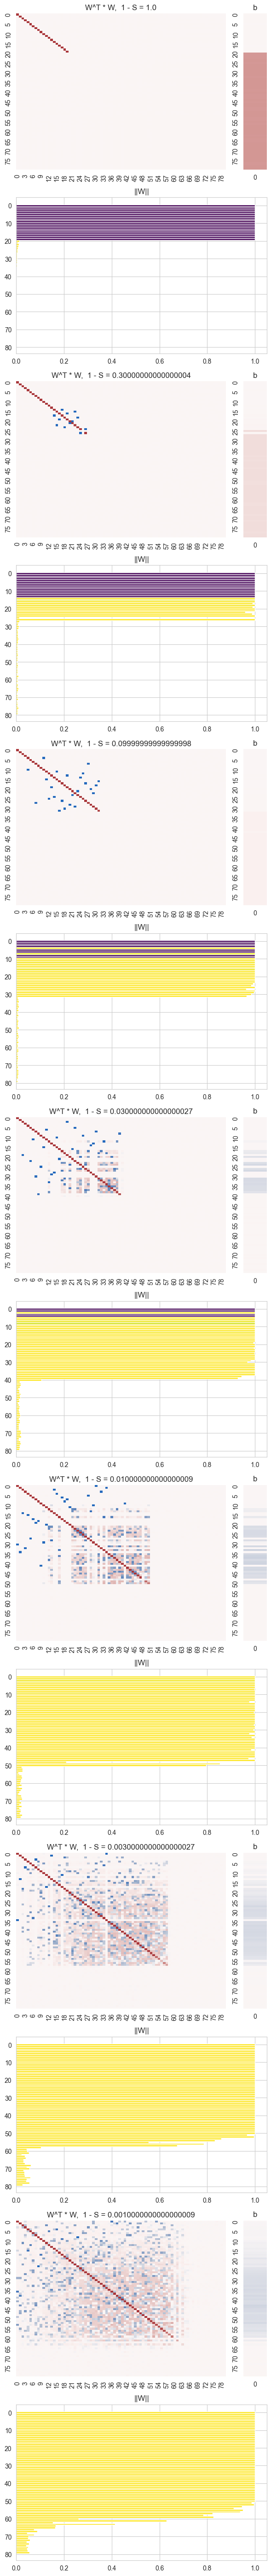

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Create a new figure with custom gridspec
fig = plt.figure(figsize=(6, 8 * n_models))
gs = gridspec.GridSpec(14, 2, height_ratios=[1, 1] * n_models, width_ratios=[9, 1])
cmap = plt.get_cmap('viridis')

for model_index in range(n_models):
    # Compute the matrix W^T * W, bias and norms for current model index
    w, b = nonlinear_model.w.detach()[model_index], nonlinear_model.b.detach()[model_index]
    matrix = w.t().mm(w).numpy()
    bias_2d = b.numpy().reshape(-1, 1)
    norm = np.linalg.norm(w.numpy(), ord=2, axis=0)
    projection_measure = compute_projection_measure(w.numpy())

    # Matrix heatmap
    ax0 = plt.subplot(gs[model_index*2, 0])
    sns.heatmap(matrix, ax=ax0, cmap='vlag', annot=False, center=0, vmin=-1, vmax=1, cbar=False)
    ax0.set_title(f"W^T * W,  1 - S = {1 - sparsity[model_index]}")

    # Bias heatmap
    ax1 = plt.subplot(gs[model_index*2, 1])
    sns.heatmap(bias_2d, ax=ax1, cmap='vlag', annot=False, center=0, vmin=-1, vmax=1, cbar=False)
    ax1.set_title("b")

    # Norm heatmap
    ax2 = plt.subplot(gs[model_index*2 + 1, :])
    ax2.barh(range(len(norm)), np.clip(norm, 0, 1), color=cmap(projection_measure), height=1)
    ax2.set_title("||W||")
    ax2.invert_yaxis()

# Display the combined figure
plt.tight_layout()
plt.show()